### Name - Vyom Chauhan
### Student ID - 30830192
### Question 5

In [1]:
# load libraries:
library(reshape2)
library(ggplot2)
library(dplyr)

Warning message:
"package 'reshape2' was built under R version 3.6.3"Warning message:
"package 'ggplot2' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



### Question 5.1
Error function for regression:<br/>
$ E_{reg} = \sum_{i = 1}^{N} (t_{i} - \pmb{w}.\phi(x_{i}))^2 $<br/>
For $L_{2}$ regularization, penalty term:<br/>
$ \lambda \sum_{m = 0}^{M-1} \pmb{w}_{m}^2 $, where $\lambda$ is the regularization parameter and M is the complexity of the linear model.<br/>
So now, the error function with $L_{2}$ regularization is:<br/>
$ Error = \sum_{i = 1}^{N} (t_{n} - \pmb{w}.\phi(x_{i}))^2 + \lambda \sum_{m = 0}^{M-1} \pmb{w}_{m}^2 $<br/>
Differentiating $Error$ w.r.t. $\pmb{w}$:<br/><br/>
$\frac{\partial Error}{\partial \pmb{w}} = - \sum_{i = 1}^{N} \phi(x_{i})(t_{i} - \pmb{w}.\phi(x_{i})) + 2\lambda \sum_{m = 0}^{M-1} \pmb{w}_{m}$<br/>
For each step we subtract the partially differentiated error with the slope value of last step. The current step is considered the solution if the step size is smaller than the threshold value. Updating weights:<br/>
$\pmb{w}^{(\tau+1)} := \pmb{w}^{(\tau)} - \eta \frac{\partial E(\pmb{w}^{(\tau)})}{\partial \pmb{w}^{(\tau)}}$<br/>
$\pmb{w}^{(\tau+1)} := \pmb{w}^{(\tau)} + \eta \sum_{i = 1}^{N} (t_{i} - \pmb{w}^{(\tau)}.\phi(x_{i}))\phi(x_{i}) - 2\eta \lambda \sum_{m = 0}^{M-1} \pmb{w}_{m}^{(\tau)}$

In [2]:
# reading the data
read_data <- function(fname, sc) {
   data <- read.csv(file=fname, head=TRUE, sep=",")
   nr = dim(data)[1]
   nc = dim(data)[2]
   x = data[1:nr,1:(nc-1)]
   y = data[1:nr,nc]
   if (isTRUE(sc)) {
      x = scale(x)
      y = scale(y)
   }
   return (list("x" = x, "y" = y))
}

In [3]:
# auxiliary function to calculate labels based on the estimated coefficients
predict_func <- function(Phi, w){
    return(Phi%*%w)
} 

In [4]:
# auxiliary function to calculate the objective function for the training
train_obj_func <- function (Phi, w, label, lambda){
    # the L2 regulariser is already included in the objective function for training 
    return(.5 * (mean((predict_func(Phi, w) - label)^2)) + .5 * lambda * w %*% w)
}

In [5]:
# auxiliary function to compute the error of the model
get_errors <- function(train_data, test_data, W, lambda) {
  n_weights = dim(W)[1]
  errors = matrix(,nrow=n_weights, ncol=2)
  colnames(errors) <- c('train', 'test')
  for (tau in 1:n_weights) {
    errors[tau,1] = train_obj_func(train_data$x, W[tau,],train_data$y, lambda)
    errors[tau,2] = train_obj_func(test_data$x, W[tau,],test_data$y, lambda)
  }
  return(errors)
}

In [6]:
# Question 5.2
# Stochastic Gradient Descent
sgd_train <- function(train_x, train_y, lambda, eta, epsilon, max_epoch) {

   train_len = dim(train_x)[1]
   tau_max = max_epoch * train_len

   W <- matrix(,nrow=tau_max, ncol=ncol(train_x)) 
   W[1,] <- runif(ncol(train_x))
  
   tau = 1 # counter 
   obj_func_val <-matrix(,nrow=tau_max, ncol=1) 
   obj_func_val[tau,1] = train_obj_func(train_x, W[tau,],train_y, lambda)

   while (tau <= tau_max){

       # check termination criteria
       if (obj_func_val[tau,1] <= epsilon) {break}
 
       # shuffle data:
       train_index <- sample(1:train_len, train_len, replace = FALSE)
    
       # loop over each datapoint
       for (i in train_index) {
           # increment the counter
           tau <- tau + 1
           if (tau > tau_max) {break}

           # make the weight update
           y_pred <- predict_func(train_x[i,], W[tau-1,])
           W[tau,] <- sgd_update_weight(W[tau-1,], train_x[i,], train_y[i], y_pred, lambda, eta)

           # keep track of the objective funtion
           obj_func_val[tau,1] = train_obj_func(train_x, W[tau,],train_y, lambda)
       }
   }
   # resulting values for the training objective function as well as the weights
   return(list('vals'=obj_func_val, 'W'=W))
}

In [7]:
# updating the weight vector
sgd_update_weight <- function(W_prev, x, y_true, y_pred, lambda, eta) {
   # adding the regularization term
   grad = c(-(y_true-y_pred)) * x + 2 * lambda * W_prev
   return (W_prev - eta * grad)
}

In [21]:
play_with_sgd <- function() {
   # reading the data
   dtrain = read_data("Task1C_train.csv", TRUE)
   dtest = read_data("Task1C_test.csv", TRUE)

   # SGD Trainng
   max_epoch = 20
   epsilon = .001
   eta = .01
   lambda = 0
   for (lambda in seq(0, 10, 0.4)){

       train_res = sgd_train(dtrain$x, dtrain$y, lambda, eta, epsilon, max_epoch)
       if (lambda == 0){
           errors = data.frame(abs(get_errors(dtrain, dtest, train_res$W, lambda)))
           errors['lambda'] <- lambda
       }
       else{
           a = data.frame(abs(get_errors(dtrain, dtest, train_res$W, lambda)))
           a['lambda'] <- lambda
           errors = rbind(errors, a)
       }
    }
    # reshape for visualization
    error_melt <- melt(errors, id='lambda')
    names(error_melt) <- c('Lambda', 'Type', 'Error')
    # grouping by Lambda and Type of Error and aggregating by mean
    error_plot <- error_melt %>%
    group_by(Lambda, Type) %>%
    summarise(avg_error = mean(Error)) %>%
    ggplot(aes(x = log(Lambda), y = avg_error, color = factor(Type))) + 
    geom_line() + 
    ggtitle('Avg. Absolute Error vs. Log Lambda')
    print(error_plot)
}

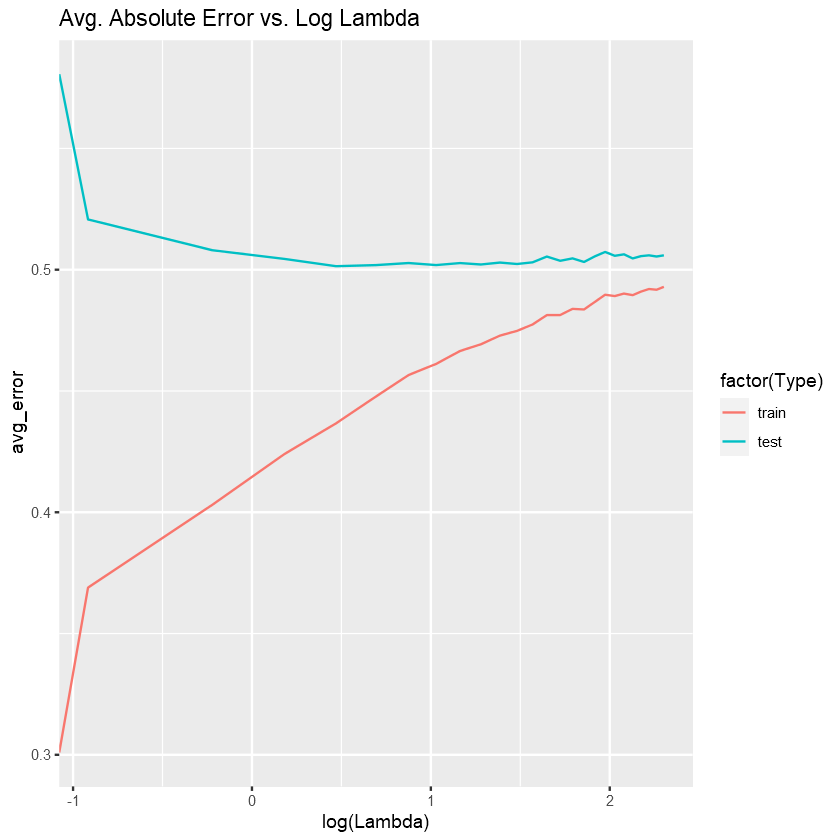

In [22]:
play_with_sgd()

### Question 5.3
#### We can see that the average test error first decreases and then gradually increases as we increase the value of lambda. While the average train error goes on increasing as we increase the value of lambda. We can say that the optimum value of lambda is 1.6 since it gives the lowest possible test error.
#### As we increase lambda we put a heavy penalty on the error function and minimize the weights assigned to the features and thereby, oversimplify the model which leads to model underfitting. While when lambda is low, we decrease the penalty which leads to heavy weights assigned to the features thereby making the model too complex i.e. overfitting. 